In [1]:
import pandas as pd
import re
import warnings
import html
import tiktoken
import time
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
from ftfy import fix_text

warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

class PhishingEmailPreprocessor:
    """
    Veri ön işleme için yazılan sınıf.
    """

    def __init__(self, csv_path:str, train_frac:float, validation_frac:float):

        self.df = None
        self.train_df = None
        self.validation_df = None
        self.test_df = None

        self.train_frac = train_frac
        self.validation_frac = validation_frac

        self.csv_path = csv_path

        self.tokenizer = tiktoken.get_encoding("gpt2")
        self.pad_token_id = 50256
        self.max_len = 1024        

        self.load_and_prepare(self.csv_path)   

    def strip_html(self,text: str) -> str:
        if not isinstance(text, str):
            return ""    
        text = html.unescape(text)
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text(separator=" ")

    def normalize_whitespace(self,text: str) -> str:
        if not isinstance(text, str):
            return ""        
        text = re.sub(r"\s+", " ", text) 
        return text.strip()

    def fix_unicode(self,text: str) -> str:
        if not isinstance(text, str): 
            return ""
        return fix_text(text)

    def create_balanced_dataset(self):
        
        num_spam = self.df[self.df["Email Type"] == 1].shape[0]
        
        ham_subset = self.df[self.df["Email Type"] == 0].sample(num_spam, random_state=123)
        
        self.df = pd.concat([ham_subset, self.df[self.df["Email Type"] == 1]]) 

    def load_and_prepare(self,csv_path: str):
        self.df = pd.read_csv(csv_path, sep=",", header=0, quotechar='"')

        self.df = self.df.dropna(subset=["Email Text", "Email Type"])
        self.df = self.df[self.df["Email Text"].astype(str).str.strip() != ""]

        self.df["Email Text"] = self.df["Email Text"].apply(self.fix_unicode)
        self.df["Email Text"] = self.df["Email Text"].apply(self.strip_html)
        self.df["Email Text"] = self.df["Email Text"].apply(self.normalize_whitespace)

        self.df = self.df[self.df["Email Text"].str.len() > 0]

        self.df = self.df.drop_duplicates(subset=["Email Text"]).copy()

        self.df["Email Type"] = self.df["Email Type"].map({"Safe Email": 0, "Phishing Email": 1})
        self.df = self.df.dropna(subset=["Email Type"])
        self.df["Email Type"] = self.df["Email Type"].astype(int)
        self.create_balanced_dataset()
        self.random_split()
        self.train_df["Token"] = self.train_df["Email Text"].apply(self.tokenize)
        self.validation_df["Token"] = self.validation_df["Email Text"].apply(self.tokenize)
        self.test_df["Token"] = self.test_df["Email Text"].apply(self.tokenize)

    def random_split(self):
        self.df = self.df.sample(frac=1, random_state=123).reset_index(drop=True)

        train_end = int(len(self.df) * self.train_frac)
        validation_end = train_end + int(len(self.df) * self.validation_frac)

        self.train_df = self.df[:train_end]
        self.validation_df = self.df[train_end:validation_end]
        self.test_df = self.df[validation_end:]

    def tokenize(self,text):
        tokens = self.tokenizer.encode(text)
        return tokens        
    
    def get_dfs(self) -> pd.DataFrame:
        self.train_df = self.train_df.drop(columns=["Unnamed: 0"])
        self.validation_df = self.validation_df.drop(columns=["Unnamed: 0"])
        self.test_df = self.test_df.drop(columns=["Unnamed: 0"])
        return self.train_df, self.validation_df, self.test_df

In [2]:
preprocessor = PhishingEmailPreprocessor("C:\\Users\\user\\Desktop\\Phishing_Email.csv\\Phishing_Email.csv",0.7,0.2)
train_df, validation_df, test_df = preprocessor.get_dfs()

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

"""
Dataframeden DataLoadera dönüşüm için aşağıdaki 2 sınıf kullanılmıştır.
"""

class EmailDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        tokens = self.df.loc[idx, "Token"]
        label = int(self.df.loc[idx, "Email Type"])
        return tokens, label


class EmailDataLoader:
    def __init__(self, train_df, val_df, test_df, batch_size=8, num_workers=0, seed=123):
        torch.manual_seed(seed)

        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_dataset = EmailDataset(train_df)
        self.val_dataset   = EmailDataset(val_df)
        self.test_dataset  = EmailDataset(test_df)
        
    #Bir batchdeki maksimum token uzunluğunu bulup batch padding yapmak için yazılmıştır.
    def make_collate_fn(self, pad_id=preprocessor.pad_token_id, max_len=None):
        def collate(batch):
            xs, ys = zip(*batch)
    
            xs_list = [x.tolist() if isinstance(x, torch.Tensor) else x for x in xs]
    
            if max_len is not None:
                xs_list = [x[:max_len] for x in xs_list]
 
            maxlen = max(len(x) for x in xs_list)
    
            X = [x + [pad_id] * (maxlen - len(x)) for x in xs_list]
            Y = list(ys)
    
            X = torch.tensor(X, dtype=torch.long)
            Y = torch.tensor(Y, dtype=torch.long)
            return X, Y
        return collate

    def get_loaders(self):
        collate = self.make_collate_fn(pad_id=preprocessor.pad_token_id, max_len=preprocessor.max_len)
        
        train_loader = DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            drop_last=True,
            collate_fn=collate,
        )

        val_loader = DataLoader(
            dataset=self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False,
            collate_fn=collate,
        )

        test_loader = DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False,
            collate_fn=collate,
        )

        return train_loader, val_loader, test_loader

In [4]:
data_module = EmailDataLoader(train_df, validation_df, test_df, batch_size=16)
train_loader, val_loader, test_loader = data_module.get_loaders()

In [5]:
import torch.nn as nn
import torch

class MultiHeadAttention(nn.Module):
    """
    Attention Sınıfı.
    """    
    
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads #

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) 
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) 
        queries = self.W_query(x)
        values = self.W_value(x)


        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)


        attn_scores = queries @ keys.transpose(2, 3)


        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]


        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)


        context_vec = (attn_weights @ values).transpose(1, 2) 

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [7]:
import torch.nn as nn
import torch

class GELU(nn.Module):
    """
    Aktivasyon fonksiyonu için yazılmış sınıf.
    """    
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) 
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 

        return x

class GPTModel(nn.Module):
    """
    Kullanılacak modelimiz.
    """          
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [8]:
#Modeli huggingface'den indirip config bilgisi ile yükledim.
file_name = "D:\\llm\\model\\gpt2-small-124M.pth"
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 1024, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": True       # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load(file_name, weights_only=True))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [9]:
#Eğitime başlamadan önce tüm ağırlıkları dondurdum.
for param in model.parameters():
    param.requires_grad = False

In [10]:
torch.manual_seed(123)

#Modelin son kısmını 2 çıkışlı network ile değiştirdim.
num_classes = 2
model.out_head = torch.nn.Linear(in_features=GPT_CONFIG_124M["emb_dim"], out_features=num_classes)
model.out_head = model.out_head.to(device)

In [11]:
#Son transformer block ve finalLayerNorm kısmını eğitim amaçlı açtım.
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [12]:
PAD_ID = 50256

#Modelde attentionda PAD mask olmadığı için en son valid token almak için yazıldı.
def last_valid_logits(xb, model, device, pad_id=PAD_ID):
    xb = xb.to(device)
    last_idx = (xb != pad_id).sum(dim=1) - 1
    logits_all = model(xb)  # [B, T, C]
    return logits_all[torch.arange(xb.size(0), device=device), last_idx, :]  # [B, C]

#cross_entropy loss kullandım.
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = last_valid_logits(input_batch, model, device, PAD_ID)
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:

        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = last_valid_logits(input_batch, model, device, PAD_ID)
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [14]:
import copy, math, torch

#Eğitim için early stopping ile kullanacağımız fonksiyon
def train_classifier_simplev2(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter,
    early_stopping=True, patience=3, min_delta=1e-3,
    restore_best_weights=True, checkpoint_path=None
):
    # Takip listeleri
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Early stopping durum değişkenleri
    best_val_loss = math.inf
    best_state_dict = None
    epochs_no_improve = 0
    best_epoch = -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() 
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1


            if global_step % eval_freq == 0 and global_step > 0:

                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter=eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")


        epoch_train_loss, epoch_val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter=None  # tamamını tara
        )

        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy   = calc_accuracy_loader(val_loader,   model, device, num_batches=eval_iter)
        print(f"[Epoch {epoch+1}] mean Train loss {epoch_train_loss:.3f}, mean Val loss {epoch_val_loss:.3f}")
        print(f"Training accuracy: {train_accuracy*100:.2f}% | Validation accuracy: {val_accuracy*100:.2f}%")

        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        # ---- EARLY STOPPING KONTROLÜ ----
        if early_stopping:
            improved = (best_val_loss - epoch_val_loss) > min_delta
            if improved:
                best_val_loss = epoch_val_loss
                best_epoch = epoch + 1
                epochs_no_improve = 0
                if restore_best_weights:
                    best_state_dict = copy.deepcopy(model.state_dict())
                if checkpoint_path:  # opsiyonel diske kaydet
                    torch.save(model.state_dict(), checkpoint_path)
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping: {patience} epoch boyunca anlamlı iyileşme yok. "
                          f"En iyi Val loss {best_val_loss:.4f} (epoch {best_epoch}).")
                    if restore_best_weights and best_state_dict is not None:
                        model.load_state_dict(best_state_dict)
                        print("Best weights geri yüklendi.")
                    break
        # ---- /EARLY STOPPING ----

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [15]:
import time

start_time = time.time()

torch.manual_seed(123)

#Optimizer olarak AdamW kullandım ve lr ile weight_decay değerlerini derste gördüğümüz örneğe göre biraz düşürdüm. (1.Eğitimde başarılı olmadı o değerler)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

num_epochs = 20 
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simplev2(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs,
    eval_freq=200,      # step içinde kısa örneklemle rapor
    eval_iter=4,       # step içi değerlendirmede kaç batch taransın
    early_stopping=True,
    patience=3,         # 3 epoch iyileşme yoksa dur
    min_delta=1e-3,     # val loss en az bu kadar düşerse "iyileşme" say
    restore_best_weights=True,
    checkpoint_path="phishing_classifier2_.pth"  # istersen "best.pt" ver
)


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000200): Train loss 1.225, Val loss 1.574
Ep 1 (Step 000400): Train loss 0.461, Val loss 0.828
[Epoch 1] mean Train loss 0.716, mean Val loss 0.719
Training accuracy: 64.06% | Validation accuracy: 71.88%
Ep 2 (Step 000600): Train loss 0.747, Val loss 0.692
Ep 2 (Step 000800): Train loss 0.634, Val loss 0.596
Ep 2 (Step 001000): Train loss 0.530, Val loss 0.522
[Epoch 2] mean Train loss 0.404, mean Val loss 0.416
Training accuracy: 84.38% | Validation accuracy: 78.12%
Ep 3 (Step 001200): Train loss 0.449, Val loss 0.456
Ep 3 (Step 001400): Train loss 0.234, Val loss 0.402
Ep 3 (Step 001600): Train loss 0.162, Val loss 0.367
[Epoch 3] mean Train loss 0.231, mean Val loss 0.251
Training accuracy: 93.75% | Validation accuracy: 79.69%
Ep 4 (Step 001800): Train loss 0.224, Val loss 0.348
Ep 4 (Step 002000): Train loss 0.119, Val loss 0.341
Ep 4 (Step 002200): Train loss 0.173, Val loss 0.337
[Epoch 4] mean Train loss 0.164, mean Val loss 0.189
Training accuracy: 92.19% | Validatio

In [16]:
torch.save(model.state_dict(), "phishing_classifier2.pth")

In [17]:
import pickle
metrics = { "train_losses": train_losses, "val_losses": val_losses, "train_accs": train_accs, "val_accs": val_accs, "examples_seen": examples_seen }
with open("metrics2.pkl", "wb") as f:
    pickle.dump(metrics, f, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
import torch
import numpy as np

@torch.no_grad()
def eval_full(val_loader, model, device, pad_id=50256):
    model.eval()
    tp = fp = tn = fn = 0
    all_probs = []
    all_y = []

    for xb, yb in val_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        # Son geçerli token'ın indeksini bul
        last_idx = (xb != pad_id).sum(dim=1) - 1

        # Logits'i o pozisyondan al
        logits_all = model(xb)                                  # [B, T, C]
        logits = logits_all[torch.arange(xb.size(0), device=device), last_idx, :]  # [B, C]

        preds = torch.argmax(logits, dim=-1)                    # [B]
        probs = torch.softmax(logits, dim=-1)[:, 1]             # positive sınıf olasılığı

        # Confusion matrix bileşenleri
        tp += ((preds == 1) & (yb == 1)).sum().item()
        tn += ((preds == 0) & (yb == 0)).sum().item()
        fp += ((preds == 1) & (yb == 0)).sum().item()
        fn += ((preds == 0) & (yb == 1)).sum().item()

        all_probs.append(probs.detach().cpu())
        all_y.append(yb.detach().cpu())

    # Temel metrikler
    total = tp + tn + fp + fn
    acc = (tp + tn) / max(1, total)
    precision = tp / max(1, tp + fp)
    recall = tp / max(1, tp + fn)
    f1 = 2 * precision * recall / max(1e-12, (precision + recall))

    # ROC-AUC (ranks yöntemi; sklearn yok)
    y_true = torch.cat(all_y).numpy()
    scores = torch.cat(all_probs).numpy()
    pos = (y_true == 1)
    n_pos = int(pos.sum())
    n_neg = len(y_true) - n_pos

    auc = None
    if n_pos > 0 and n_neg > 0:
        order = np.argsort(scores)
        ranks = np.empty_like(order)
        ranks[order] = np.arange(len(scores)) + 1
        sum_ranks_pos = ranks[pos].sum()
        auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": auc, 
        "confusion_matrix": {"tn": tn, "fp": fp, "fn": fn, "tp": tp},
    }

metrics = eval_full(val_loader, model, device)
print(metrics)

{'accuracy': 0.9732108687332568, 'precision': 0.9845679012345679, 'recall': 0.9622926093514329, 'f1': 0.973302822273074, 'roc_auc': np.float64(0.9968937548123068), 'confusion_matrix': {'tn': 1267, 'fp': 20, 'fn': 50, 'tp': 1276}}


In [20]:
test_metrics = eval_full(test_loader, model, device, pad_id=50256)

In [21]:
test_metrics

{'accuracy': 0.9686544342507645,
 'precision': 0.9734375,
 'recall': 0.9629057187017002,
 'f1': 0.9681429681429681,
 'roc_auc': np.float64(0.9965627462488338),
 'confusion_matrix': {'tn': 644, 'fp': 17, 'fn': 24, 'tp': 623}}

Fitting 3 folds for each of 24 candidates, totalling 72 fits


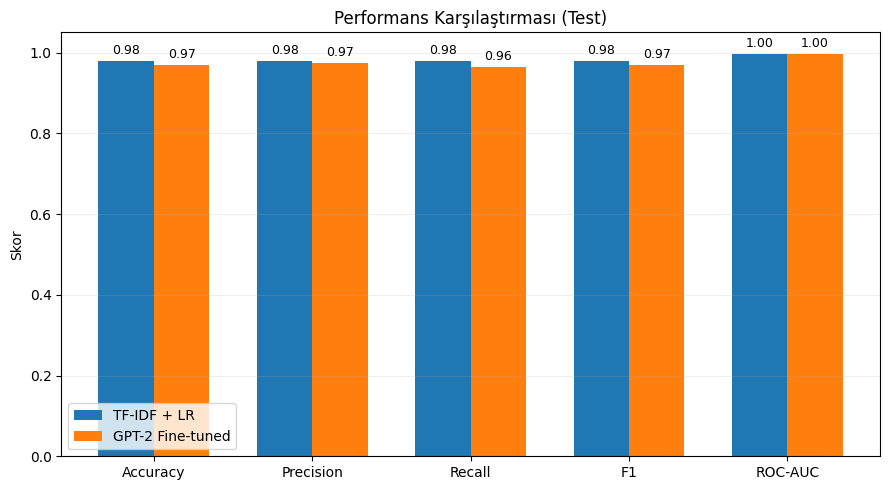

In [22]:
#TF-IDF vs fine-tuned GPT2-small 
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

X_train = train_df["Email Text"].astype(str).values
y_train = train_df["Email Type"].astype(int).values

X_val   = validation_df["Email Text"].astype(str).values
y_val   = validation_df["Email Type"].astype(int).values

X_test  = test_df["Email Text"].astype(str).values
y_test  = test_df["Email Type"].astype(int).values

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=False,
        strip_accents="unicode",   
        sublinear_tf=True
    )),
    ("lr", LogisticRegression(
        max_iter=2000,
        n_jobs=None,               
        solver="liblinear"        
    ))
])

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [2, 5],
    "tfidf__max_features": [None, 100_000],
    "lr__C": [0.5, 1.0, 2.0],
    "lr__penalty": ["l2"]        
}

gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1",       
    cv=3,
    n_jobs=-1,
    verbose=1
)
gs.fit(X_train, y_train)

baseline = gs.best_estimator_

# === 3) Validation ve Test performansı ===
def evaluate(model, X, y):
    proba = model.predict_proba(X)[:,1]
    pred  = (proba >= 0.5).astype(int)
    return {
        "accuracy":  accuracy_score(y, pred),
        "precision": precision_score(y, pred, zero_division=0),
        "recall":    recall_score(y, pred, zero_division=0),
        "f1":        f1_score(y, pred, zero_division=0),
        "roc_auc":   roc_auc_score(y, proba),
        "confusion_matrix": confusion_matrix(y, pred, labels=[0,1])
    }

baseline_val  = evaluate(baseline, X_val,  y_val)
baseline_test = evaluate(baseline, X_test, y_test)

# GPT2 test veri setindeki sonuçlarım.
gpt2_test = {
    "accuracy": 0.9686544342507645,
    "precision": 0.9734375,
    "recall": 0.9629057187017002,
    "f1": 0.9681429681429681,
    "roc_auc": 0.9965627462488338,
    "confusion_matrix": np.array([[644, 17],[24, 623]])
}


def plot_compare(baseline_metrics, gpt2_metrics, title_suffix="(Test Set)"):
    labels = ["Accuracy","Precision","Recall","F1","ROC-AUC"]
    base_vals = [baseline_metrics[k.lower()] for k in ["ACCURACY","PRECISION","RECALL","F1","ROC_AUC"]]
    gpt2_vals = [gpt2_metrics[k.lower()]    for k in ["ACCURACY","PRECISION","RECALL","F1","ROC_AUC"]]

    x = np.arange(len(labels))
    w = 0.35
    plt.figure(figsize=(9,5))
    b1 = plt.bar(x - w/2, base_vals, width=w, label="TF-IDF + LR")
    b2 = plt.bar(x + w/2, gpt2_vals, width=w, label="GPT-2 Fine-tuned")
    for bars in [b1, b2]:
        for b in bars:
            h = b.get_height()
            plt.text(b.get_x() + b.get_width()/2, h+0.01, f"{h:.2f}", ha="center", va="bottom", fontsize=9)
    plt.ylim(0,1.05)
    plt.xticks(x, labels)
    plt.title(f"Performans Karşılaştırması {title_suffix}")
    plt.ylabel("Skor")
    plt.legend()
    plt.grid(axis="y", alpha=0.2)
    plt.tight_layout()
    plt.show()

plot_compare(baseline_test, gpt2_test, "(Test)")